In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import time
import os
import csv
from citylearn.citylearn import CityLearnEnv
from citylearn.reward_function import ComfortReward, SolarPenaltyReward, SolarPenaltyAndComfortReward, MARL, IndependentSACReward

#from agents.user_agent import SubmissionAgent
#from rewards.user_reward import SubmissionReward
from stable_baselines3.sac import SAC
from stable_baselines3.ppo import PPO
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper

from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
class WrapperEnv:
    """
    Env to wrap provide Citylearn Env data without providing full env
    Preventing attribute access outside of the available functions
    """
    def __init__(self, env_data):
        self.observation_names = env_data['observation_names']
        self.action_names = env_data['action_names']
        self.observation_space = env_data['observation_space']
        self.action_space = env_data['action_space']
        self.time_steps = env_data['time_steps']
        self.seconds_per_time_step = env_data['seconds_per_time_step']
        self.random_seed = env_data['random_seed']
        self.buildings_metadata = env_data['buildings_metadata']
        self.episode_tracker = env_data['episode_tracker']
    
    def get_metadata(self):
        return {'buildings': self.buildings_metadata}

def create_citylearn_env(config, reward_function):
    env = CityLearnEnv(config.SCHEMA, reward_function=reward_function)

    env_data = dict(
        observation_names = env.observation_names,
        action_names = env.action_names,
        observation_space = env.observation_space,
        action_space = env.action_space,
        time_steps = env.time_steps,
        random_seed = None,
        episode_tracker = None,
        seconds_per_time_step = None,
        buildings_metadata = env.get_metadata()['buildings']
    )

    wrapper_env = WrapperEnv(env_data)
    return env, wrapper_env


def update_power_outage_random_seed(env: CityLearnEnv, random_seed: int) -> CityLearnEnv:
    """Update random seed used in generating power outage signals.
    
    Used to optionally update random seed for stochastic power outage model in all buildings.
    Random seeds should be updated before calling :py:meth:`citylearn.citylearn.CityLearnEnv.reset`.
    """

    for b in env.buildings:
        b.stochastic_power_outage_model.random_seed = random_seed

    return env

In [4]:
class Config:
    data_dir = './data/'
    SCHEMA = os.path.join(data_dir, 'schemas/warm_up/schema.json')
    num_episodes = 1
    
config = Config()

# Pour créer les agents

In [31]:
env = []
wrapper_env = []

#Comfort Reward
env.append(create_citylearn_env(config, ComfortReward)[0])
wrapper_env.append(create_citylearn_env(config, ComfortReward)[1])

#Solar Penalty Reward
env.append(create_citylearn_env(config, SolarPenaltyReward)[0])
wrapper_env.append(create_citylearn_env(config, SolarPenaltyReward)[1])

#Solar Penalty And Comfort Reward
env.append(create_citylearn_env(config, SolarPenaltyAndComfortReward)[0])
wrapper_env.append(create_citylearn_env(config, SolarPenaltyAndComfortReward)[1])

#MARL
env.append(create_citylearn_env(config, MARL)[0])
wrapper_env.append(create_citylearn_env(config, MARL)[1])

#Independent SAC Reward
env.append(create_citylearn_env(config, IndependentSACReward)[0])
wrapper_env.append(create_citylearn_env(config, IndependentSACReward)[1])

In [32]:
for i in range(0,5):
    env[i] = NormalizedObservationWrapper(env[i])
    env[i] = StableBaselines3Wrapper(env[i])

In [33]:
#création de 5 agents (1 pour chaque reward)
agent = []
for i in range(0,5):
    agent.append(PPO('MlpPolicy', env[i]))

In [34]:
#métrique
def ScoreControl(w1,w2,w3,w4,i,epochTrains):
    ScoreComfort = U[i][epochTrains]
    ScoreEmission = G[i][epochTrains]
    ScoreGrid = R[i][epochTrains] + L[i][epochTrains] + Pd[i][epochTrains] + Pn[i][epochTrains]
    ScoreResilience = M[i][epochTrains] + S[i][epochTrains]
    return w1*ScoreComfort+ w2*ScoreEmission + w3*ScoreGrid + w4*ScoreResilience

In [35]:
# Phase 1
w1_p1 = 0.3
w2_p1 = 0.1
w3_p1 = 0.6
w4_p1 = 0.0

# Phase 2
w1_p2 = 0.3
w2_p2 = 0.1
w3_p2 = 0.3
w4_p2 = 0.3

# initialisation des listes

In [36]:
#Pour chaque kpi, on a 5 listes pour les 5 rewards, contenant chacune les valeurs correspondant à chaque epoch
G = [[],[],[],[],[]]
U = [[],[],[],[],[]]
R = [[],[],[],[],[]]
L = [[],[],[],[],[]]
Pd = [[],[],[],[],[]]
Pn = [[],[],[],[],[]]
M = [[],[],[],[],[]]
S = [[],[],[],[],[]]

#liste de dataframe
kpis = [[],[],[],[],[]]

#ScoreControl pour chaque reward, pour chaque epoch
Score = [[],[],[],[],[]]

RewardFunc = ['ComfortReward','SolarPenaltyReward','SolarPenaltyAndComfortReward','MARL','IndependentSACReward']

epochInit = 0
epochEnd = 50

# Training

In [38]:
for epochTrains in tqdm(range(epochInit,epochEnd)):#changer le début du range si reprise d'entraienement
    for i in range(0,5): #Pour chaque agent (ayant une reward différente)
        agent[i].learn(total_timesteps=env[i].time_steps*2)
        agent[i].save("./models/{}/PPOModel_{}epoch".format(RewardFunc[i],epochTrains*2))
        
        kpis[i] = env[i].evaluate()
        kpis[i] = kpis[i].pivot(index='cost_function',columns='name',values='value')

        #On prend seulement les valeurs du District
        #.loc retourne des tuples, il faut les convertir en float
        #carbon emission
        G[i].append(float(kpis[i].loc['carbon_emissions_total','District']))
        #unmet hours
        U[i].append(float(kpis[i].loc['discomfort_proportion','District']))
        #ramping
        R[i].append(float(kpis[i].loc['ramping_average','District']))
        #1 - load factor
        L[i].append(float(kpis[i].loc['daily_one_minus_load_factor_average','District']))
        #daily peak
        Pd[i].append(float(kpis[i].loc['daily_peak_average','District']))
        #all-time peak
        Pn[i].append(float(kpis[i].loc['annual_peak_average','District']))
        #1 - thermal resilience
        M[i].append(float(kpis[i].loc['one_minus_thermal_resilience_proportion','District']))
        #Normalized unserved energy
        S[i].append(float(kpis[i].loc['power_outage_normalized_unserved_energy_total','District']))
        
        #On s'intéresse seulement à la phase 2 pour le calcul du score
        Score[i].append(ScoreControl(w1_p2,w2_p2,w3_p2,w4_p2,i,epochTrains-epochInit))


  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\Felix\Anaconda3\envs\citylearn\lib\site-packages\stable_baselines3\common\save_util.py:278: UserWarning: Path 'models\IndependentSACReward' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")
100%|██████████| 50/50 [2:47:00<00:00, 200.41s/it]  


# Résultats

In [39]:
#liste des scores à chaque epoch pour chaque reward function
for i in range(0,5):
    print(RewardFunc[i],' :', Score[i])

ComfortReward  : [2.501416266504189, 2.3651565971826525, 2.5046836244416175, 2.364343889208782, 2.289805758646348, 2.2397327419387283, 2.309679551418904, 2.248821095273613, 2.1194014388966163, 2.1691171560104228, 2.227584769349376, 2.297686786084728, 2.188431995598115, 2.2564573153017453, 2.224042063761729, 2.2591643991962997, 2.099520859969593, 2.1253884427511824, 2.2650256135047613, 2.0877878772046987, 2.180116010982705, 2.1206458178385788, 2.1105551440680337, 2.224334682368288, 2.148093394985582, 2.280286751190506, 2.151381942601186, 2.2534472817021185, 2.1454377959436286, 2.0880329351841715, 2.243786758915916, 2.2620819125654275, 2.1872540053113094, 2.209548700585679, 2.0636159088920376, 2.2000121362635037, 2.2134520787944822, 2.2238271842596156, 2.1081823551233065, 2.248636063275387, 2.2132176142006115, 2.0894368525826748, 2.108838079716755, 2.2549703864296036, 2.1696099916909013, 2.1339616625847055, 2.2088150697386686, 2.2769985556584467, 2.303317979881909, 2.2070411710666034]
So

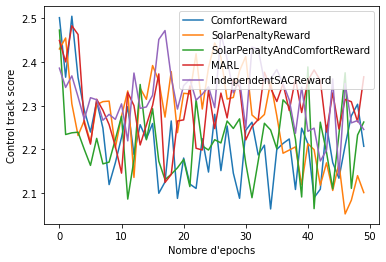

In [59]:
#graphique des scores
for i in range(0,5):
    plt.plot(Score[i],label=RewardFunc[i])
plt.xlabel('Nombre d\'epochs')
plt.ylabel('Control track score')
plt.legend()
plt.savefig('Graphique ScoreControl')

In [46]:
#score minimum pour chaque reward function
for i in range(0,5):
    print(RewardFunc[i],'score minimal atteint a l\'epoch', np.argmin(Score[i]), ':', min(Score[i]))

ComfortReward score minimal atteint a l'epoch 34 : 2.0636159088920376
SolarPenaltyReward score minimal atteint a l'epoch 46 : 2.052272703709754
SolarPenaltyAndComfortReward score minimal atteint a l'epoch 41 : 2.0643627230411425
MARL score minimal atteint a l'epoch 17 : 2.1242525266927337
IndependentSACReward score minimal atteint a l'epoch 45 : 2.140855172226506


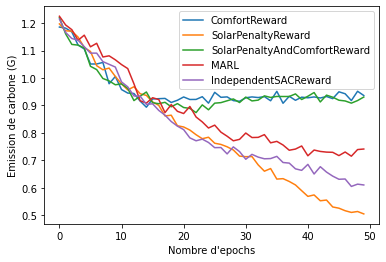

In [60]:
#Graphique de l'emission de carbone (G) pour chaque reward function
#Il s'agit aussi du score d'émission
for i in range(0,5):
    plt.plot(G[i],label=RewardFunc[i])
plt.xlabel('Nombre d\'epochs')
plt.ylabel('Emission de carbone (G)')
plt.legend()
plt.savefig('Graphique G')

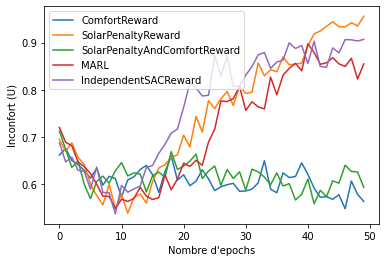

In [61]:
#Graphique de l'inconfort ou heure insatisfaite (U) pour chaque reward function
#Il s'agit aussi du score de confort
for i in range(0,5):
    plt.plot(U[i],label=RewardFunc[i])
plt.xlabel('Nombre d\'epochs')
plt.ylabel('Inconfort (U)')
plt.legend()
plt.savefig('Graphique U')

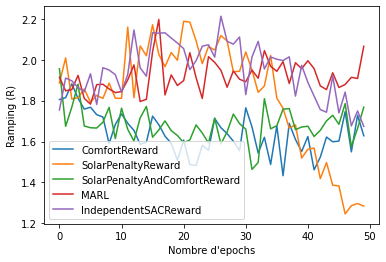

In [62]:
#Graphique du ramping (R) pour chaque reward function
for i in range(0,5):
    plt.plot(R[i],label=RewardFunc[i])
plt.xlabel('Nombre d\'epochs')
plt.ylabel('Ramping (R)')
plt.legend()
plt.savefig('Graphique R')

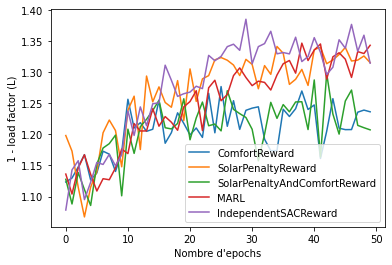

In [63]:
#Graphique de 1-load factor (L) pour chaque reward function
for i in range(0,5):
    plt.plot(L[i],label=RewardFunc[i])
plt.xlabel('Nombre d\'epochs')
plt.ylabel('1 - load factor (L)')
plt.legend()
plt.savefig('Graphique L')

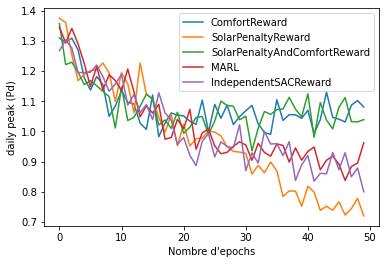

In [64]:
#Graphique de daily peak (Pd) pour chaque reward function
for i in range(0,5):
    plt.plot(Pd[i],label=RewardFunc[i])
plt.xlabel('Nombre d\'epochs')
plt.ylabel('daily peak (Pd)')
plt.legend()
plt.savefig('Graphique Pd')

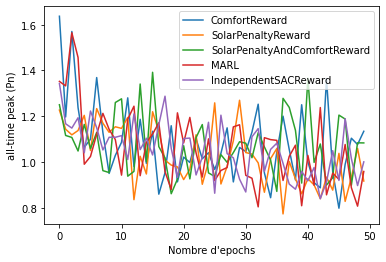

In [65]:
#Graphique de all-time peak (Pn) pour chaque reward function
for i in range(0,5):
    plt.plot(Pn[i],label=RewardFunc[i])
plt.xlabel('Nombre d\'epochs')
plt.ylabel('all-time peak (Pn)')
plt.legend()
plt.savefig('Graphique Pn')

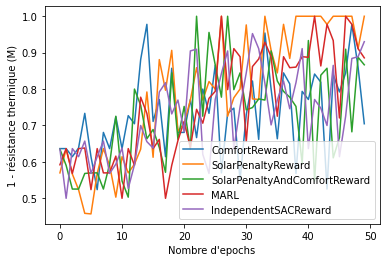

In [66]:
#Graphique de 1 - résistance thermique (M) pour chaque reward function
for i in range(0,5):
    plt.plot(M[i],label=RewardFunc[i])
plt.xlabel('Nombre d\'epochs')
plt.ylabel('1 - résistance thermique (M)')
plt.legend()
plt.savefig('Graphique M')

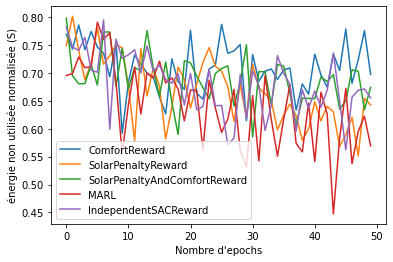

In [67]:
#Graphique d'énergie non utilisée normalisée (S) pour chaque reward function
for i in range(0,5):
    plt.plot(S[i],label=RewardFunc[i])
plt.xlabel('Nombre d\'epochs')
plt.ylabel('énergie non utilisée normalisée (S)')
plt.legend()
plt.savefig('Graphique S')

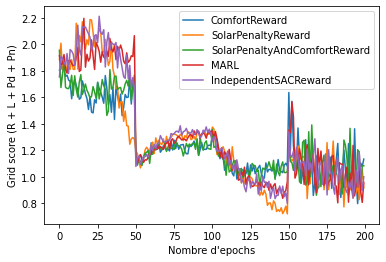

In [68]:
#Graphique du grid score (R + L + Pd + Pn) pour chaque reward function
for i in range(0,5):
    plt.plot(R[i] + L[i] + Pd[i] + Pn[i],label=RewardFunc[i])
plt.xlabel('Nombre d\'epochs')
plt.ylabel('Grid score (R + L + Pd + Pn)')
plt.legend()
plt.savefig('Graphique ScoreGrid')

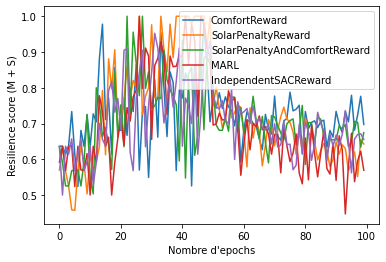

In [69]:
#Graphique du resilience score (M + S) pour chaque reward function
for i in range(0,5):
    plt.plot(M[i] + S[i],label=RewardFunc[i])
plt.xlabel('Nombre d\'epochs')
plt.ylabel('Resilience score (M + S)')
plt.legend()
plt.savefig('Graphique ScoreResilience')

# Pour import un agent

In [5]:
env, wrapper_env = create_citylearn_env(config, ComfortReward)

In [6]:
env = NormalizedObservationWrapper(env)
env = StableBaselines3Wrapper(env)

In [7]:
agent = PPO('MlpPolicy', env)
agent.load("./models/SolarPenaltyReward/PPOModel_92epoch") #à changer selon l'agent qu'on veut importer
agent.learn(total_timesteps=env.time_steps)

In [9]:
kpis=env.evaluate()
kpis=kpis.pivot(index='cost_function',columns='name',values='value')
kpis

name,Building_1,Building_2,Building_3,District
cost_function,,,,
annual_normalized_unserved_energy_total,0.012804,0.019098,0.021081,0.017661
annual_peak_average,NaN,NaN,NaN,1.262812
carbon_emissions_total,1.223417,1.316120,1.134386,1.224641
cost_total,1.195233,1.303915,1.120391,1.206513
daily_one_minus_load_factor_average,NaN,NaN,NaN,1.067114
daily_peak_average,NaN,NaN,NaN,1.266355
discomfort_delta_average,-5.998705,-2.221172,-1.627210,-3.282362
discomfort_delta_maximum,5.025061,6.766607,5.014055,5.601908
discomfort_delta_minimum,-14.532576,-11.641537,-6.114584,-10.762899


In [10]:
#On prend seulement les valeurs du District
#.loc retourne des tuples, il faut les convertir en float
#carbon emission
G = float(kpis.loc['carbon_emissions_total','District'])
#unmet hours
U = float(kpis.loc['discomfort_proportion','District'])
#ramping
R = float(kpis.loc['ramping_average','District'])
#1 - load factor
L = float(kpis.loc['daily_one_minus_load_factor_average','District'])
#daily peak
Pd = float(kpis.loc['daily_peak_average','District'])
#all-time peak
Pn = float(kpis.loc['annual_peak_average','District'])
#1 - thermal resilience
M = float(kpis.loc['one_minus_thermal_resilience_proportion','District'])
#Normalized unserved energy
S = float(kpis.loc['power_outage_normalized_unserved_energy_total','District'])

In [11]:
def ScoreControl2(w1,w2,w3,w4):
    ScoreComfort = U
    ScoreEmission = G
    ScoreGrid = R + L + Pd + Pn
    ScoreResilience = M + S
    return w1*ScoreComfort+ w2*ScoreEmission + w3*ScoreGrid + w4*ScoreResilience

In [13]:
# Phase 1
w1_p1 = 0.3
w2_p1 = 0.1
w3_p1 = 0.6
w4_p1 = 0.0

# Phase 2
w1_p2 = 0.3
w2_p2 = 0.1
w3_p2 = 0.3
w4_p2 = 0.3

In [15]:
print(ScoreControl2(w1_p2,w2_p2,w3_p2,w4_p2))

2.3520903793268406
